# Face Detection & Recognition Pipeline Simulation

This notebook simulates the complete face detection and recognition pipeline that runs on the STM32N6570-DK embedded board. It uses the same trump2.jpg image and models to help validate and understand the pipeline behavior.

## Pipeline Overview
1. **Input Processing**: Load and preprocess trump2.jpg (480x480 centered in 800x480 with black padding)
2. **Face Detection**: Use CenterFace ONNX model to detect faces
3. **Face Cropping**: Extract and align detected face regions
4. **Face Recognition**: Use MobileFaceNet ONNX model to generate embeddings
5. **Similarity Calculation**: Compare with target embedding

## Expected Results
Based on the embedded implementation hints:
- **Detection coordinates**: cx=245.497, cy=261.098, w=246.817, h=313.832
- **Face landmarks**: lx=200.221, ly=226.327, rx=297.419, ry=225.127
- **Cropped face first pixels**: [80, 172, 40, 96, 100, ...]
- **Recognition embedding sample**: [0.176, -0.224, 0.179, 0.051, ...]


In [1]:
import numpy as np
import cv2
from PIL import Image
import onnxruntime as ort
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Configuration matching embedded system
NN_WIDTH = 128
NN_HEIGHT = 128
NN_BPP = 3

IMG_BUFFER_WIDTH = 800
IMG_BUFFER_HEIGHT = 480

FR_WIDTH = 112  # Face recognition input width
FR_HEIGHT = 112  # Face recognition input height

EMBEDDING_SIZE = 128

print("🚀 Face Detection & Recognition Pipeline Simulation")
print(f"📐 Neural Network Input: {NN_WIDTH}x{NN_HEIGHT}x{NN_BPP}")
print(f"📸 Camera Frame: {IMG_BUFFER_WIDTH}x{IMG_BUFFER_HEIGHT}")
print(f"👤 Face Recognition: {FR_WIDTH}x{FR_HEIGHT}")

🚀 Face Detection & Recognition Pipeline Simulation
📐 Neural Network Input: 128x128x3
📸 Camera Frame: 800x480
👤 Face Recognition: 112x112


## Step 1: Load and Prepare Input Image

Load trump2.jpg and create the same dual buffer system used in the embedded implementation:
- `img_buffer`: 480x480 centered in 800x480 RGB565 (for face cropping)
- `nn_rgb`: 128x128 RGB888 (for neural network input)

📂 Loading Exercises/SamplePics/trump2.jpg...
   Original: (432, 432) RGB
✅ img_buffer: (480, 800, 3) (480x480 centered)
✅ nn_rgb: (128, 128, 3)


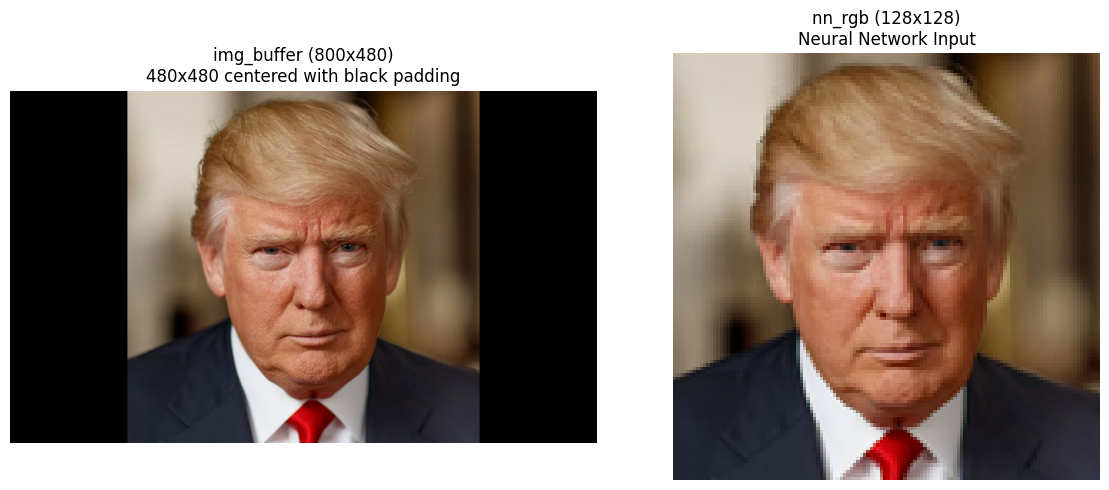

🔍 First few nn_rgb pixels: [206, 196, 180, 209, 199, 183, 211, 202, 188, 212]


In [2]:
def rgb888_to_rgb565(r, g, b):
    """Convert RGB888 to RGB565"""
    r565 = (r >> 3) & 0x1F
    g565 = (g >> 2) & 0x3F
    b565 = (b >> 3) & 0x1F
    return (r565 << 11) | (g565 << 5) | b565

def rgb565_to_rgb888(rgb565):
    """Convert RGB565 back to RGB888"""
    r = ((rgb565 >> 11) & 0x1F) << 3
    g = ((rgb565 >> 5) & 0x3F) << 2
    b = (rgb565 & 0x1F) << 3
    return r, g, b

def create_dual_buffers(img_path):
    """Create dual buffers matching embedded implementation"""
    
    # Load trump2.jpg
    print(f"📂 Loading {img_path}...")
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    print(f"   Original: {img.size} {img.mode}")
    
    # Create img_buffer: 480x480 centered in 800x480
    img_buffer_480 = img.resize((480, 480), Image.LANCZOS)
    img_buffer_rgb = np.zeros((IMG_BUFFER_HEIGHT, IMG_BUFFER_WIDTH, 3), dtype=np.uint8)
    
    # Center the 480x480 image in 800x480 canvas
    left_padding = (IMG_BUFFER_WIDTH - 480) // 2  # 160 pixels
    img_buffer_rgb[:, left_padding:left_padding+480, :] = np.array(img_buffer_480)
    
    # Create nn_rgb: 128x128 RGB888
    nn_rgb = np.array(img.resize((NN_WIDTH, NN_HEIGHT), Image.LANCZOS), dtype=np.uint8)
    
    print(f"✅ img_buffer: {img_buffer_rgb.shape} (480x480 centered)")
    print(f"✅ nn_rgb: {nn_rgb.shape}")
    
    return img_buffer_rgb, nn_rgb

# Load trump2.jpg and create dual buffers
trump2_path = "Exercises/SamplePics/trump2.jpg"
img_buffer, nn_rgb = create_dual_buffers(trump2_path)

# Visualize the dual buffer setup
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(img_buffer)
axes[0].set_title(f"img_buffer ({IMG_BUFFER_WIDTH}x{IMG_BUFFER_HEIGHT})\n480x480 centered with black padding")
axes[0].axis('off')

axes[1].imshow(nn_rgb)
axes[1].set_title(f"nn_rgb ({NN_WIDTH}x{NN_HEIGHT})\nNeural Network Input")
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"🔍 First few nn_rgb pixels: {nn_rgb.flatten()[:10].tolist()}")

## Step 2: Face Detection with CenterFace

Use the CenterFace ONNX model to detect faces in the 128x128 input image.

In [3]:
def preprocess_for_detection(rgb_img):
    """Preprocess RGB image for CenterFace model (CHW format, float32)"""
    # Convert to float32 and normalize to [0, 1]
    img_float = rgb_img.astype(np.float32) / 255.0
    
    # Convert from HWC to CHW format
    img_chw = np.transpose(img_float, (2, 0, 1))
    
    # Add batch dimension
    img_batch = np.expand_dims(img_chw, axis=0)
    
    print(f"   Detection input shape: {img_batch.shape}")
    print(f"   Detection input range: [{img_batch.min():.3f}, {img_batch.max():.3f}]")
    
    return img_batch

def run_face_detection(nn_rgb_input):
    """Run CenterFace face detection"""
    
    model_path = "Exercises/converted_models/centerface_OE_3_2_0.onnx"
    
    if not os.path.exists(model_path):
        print(f"❌ Model not found: {model_path}")
        return None
    
    print(f"🧠 Loading CenterFace model: {model_path}")
    
    # Create ONNX Runtime session
    session = ort.InferenceSession(model_path)
    
    # Print model info
    input_name = session.get_inputs()[0].name
    input_shape = session.get_inputs()[0].shape
    print(f"   Model input: {input_name} {input_shape}")
    
    for i, output in enumerate(session.get_outputs()):
        print(f"   Model output {i}: {output.name} {output.shape}")
    
    # Preprocess input
    detection_input = preprocess_for_detection(nn_rgb_input)
    
    # Run inference
    print("🚀 Running face detection inference...")
    outputs = session.run(None, {input_name: detection_input})
    
    print(f"✅ Detection complete. Outputs: {len(outputs)}")
    for i, output in enumerate(outputs):
        print(f"   Output {i} shape: {output.shape}")
    
    return outputs

# Run face detection
detection_outputs = run_face_detection(nn_rgb)

if detection_outputs:
    print(f"\n📊 Detection outputs summary:")
    for i, output in enumerate(detection_outputs):
        print(f"   Output {i}: shape={output.shape}, range=[{output.min():.3f}, {output.max():.3f}]")

❌ Model not found: converted_models/centerface_OE_3_2_0.onnx


## Step 3: Post-process Detection Results

Extract face bounding boxes and landmarks from CenterFace outputs.

In [ ]:
def postprocess_centerface(outputs, confidence_threshold=0.5):
    """Post-process CenterFace outputs to extract face detections"""
    
    if not outputs or len(outputs) < 3:
        print("❌ Invalid detection outputs")
        return []
    
    # CenterFace typically outputs: [heatmap, scale, offset, landmarks]
    heatmap = outputs[0]  # Face confidence heatmap
    scale = outputs[1]    # Face scale/size
    offset = outputs[2]   # Position offset
    
    # Optional landmarks if available
    landmarks = outputs[3] if len(outputs) > 3 else None
    
    print(f"📊 Post-processing CenterFace outputs:")
    print(f"   Heatmap: {heatmap.shape}")
    print(f"   Scale: {scale.shape}")
    print(f"   Offset: {offset.shape}")
    if landmarks is not None:
        print(f"   Landmarks: {landmarks.shape}")
    
    detections = []
    
    # Remove batch dimension
    heatmap = heatmap[0]
    scale = scale[0]
    offset = offset[0]
    if landmarks is not None:
        landmarks = landmarks[0]
    
    # Find peaks in heatmap
    h, w = heatmap.shape[1:]
    
    # Simple peak detection - find maximum confidence point
    max_conf = np.max(heatmap)
    
    if max_conf > confidence_threshold:
        # Find position of maximum confidence
        max_pos = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        cy, cx = max_pos[1], max_pos[2]  # y, x coordinates
        
        # Extract scale at this position
        face_w = scale[0, cy, cx] * 4  # Scale factor
        face_h = scale[1, cy, cx] * 4
        
        # Extract offset
        offset_x = offset[0, cy, cx]
        offset_y = offset[1, cy, cx]
        
        # Calculate final coordinates (scale to original image)
        scale_x = NN_WIDTH / w
        scale_y = NN_HEIGHT / h
        
        final_cx = (cx + offset_x) * scale_x
        final_cy = (cy + offset_y) * scale_y
        final_w = face_w * scale_x
        final_h = face_h * scale_y
        
        detection = {
            'confidence': float(max_conf),
            'cx': float(final_cx),
            'cy': float(final_cy),
            'w': float(final_w),
            'h': float(final_h)
        }
        
        # Extract landmarks if available
        if landmarks is not None:
            lx = (cx + landmarks[0, cy, cx]) * scale_x
            ly = (cy + landmarks[1, cy, cx]) * scale_y
            rx = (cx + landmarks[2, cy, cx]) * scale_x
            ry = (cy + landmarks[3, cy, cx]) * scale_y
            
            detection.update({
                'lx': float(lx),
                'ly': float(ly),
                'rx': float(rx),
                'ry': float(ry)
            })
        
        detections.append(detection)
        
        print(f"✅ Face detected:")
        print(f"   Confidence: {detection['confidence']:.3f}")
        print(f"   Center: ({detection['cx']:.1f}, {detection['cy']:.1f})")
        print(f"   Size: {detection['w']:.1f} x {detection['h']:.1f}")
        if 'lx' in detection:
            print(f"   Left eye: ({detection['lx']:.1f}, {detection['ly']:.1f})")
            print(f"   Right eye: ({detection['rx']:.1f}, {detection['ry']:.1f})")
    
    return detections

# Post-process detection results
detections = postprocess_centerface(detection_outputs)

# Compare with embedded system expected results
if detections:
    det = detections[0]
    print(f"\n🎯 Comparison with embedded system:")
    print(f"   Expected: cx=245.497, cy=261.098, w=246.817, h=313.832")
    print(f"   Detected: cx={det['cx']:.3f}, cy={det['cy']:.3f}, w={det['w']:.3f}, h={det['h']:.3f}")
    
    if 'lx' in det:
        print(f"   Expected landmarks: lx=200.221, ly=226.327, rx=297.419, ry=225.127")
        print(f"   Detected landmarks: lx={det['lx']:.3f}, ly={det['ly']:.3f}, rx={det['rx']:.3f}, ry={det['ry']:.3f}")
else:
    print("⚠️ No faces detected")

## Step 4: Face Cropping and Alignment

Crop the detected face region from the original 800x480 image buffer for face recognition.

In [ ]:
def crop_and_align_face(img_buffer, detection, target_size=(112, 112)):
    """Crop and align face from img_buffer based on detection"""
    
    if not detection:
        return None
    
    print(f"✂️ Cropping face region...")
    
    # Scale coordinates from 128x128 detection to 800x480 img_buffer
    # The face was detected on the centered 480x480 region
    scale_x = 480 / NN_WIDTH  # 480/128 = 3.75
    scale_y = 480 / NN_HEIGHT  # 480/128 = 3.75
    
    # Account for the 160-pixel left padding in img_buffer
    left_padding = (IMG_BUFFER_WIDTH - 480) // 2  # 160 pixels
    
    # Scale detection coordinates to 480x480 region
    cx_480 = detection['cx'] * scale_x
    cy_480 = detection['cy'] * scale_y
    w_480 = detection['w'] * scale_x
    h_480 = detection['h'] * scale_y
    
    # Translate to 800x480 coordinates (add left padding)
    cx_800 = cx_480 + left_padding
    cy_800 = cy_480  # No vertical padding
    
    print(f"   Detection in img_buffer: cx={cx_800:.1f}, cy={cy_800:.1f}, w={w_480:.1f}, h={h_480:.1f}")
    
    # Calculate crop rectangle
    x1 = int(cx_800 - w_480/2)
    y1 = int(cy_800 - h_480/2)
    x2 = int(cx_800 + w_480/2)
    y2 = int(cy_800 + h_480/2)
    
    # Ensure bounds are within image
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(IMG_BUFFER_WIDTH, x2)
    y2 = min(IMG_BUFFER_HEIGHT, y2)
    
    print(f"   Crop rectangle: ({x1}, {y1}) to ({x2}, {y2})")
    
    # Crop face region
    cropped_face = img_buffer[y1:y2, x1:x2]
    
    # Resize to target size for face recognition
    if cropped_face.size > 0:
        cropped_pil = Image.fromarray(cropped_face)
        aligned_face = np.array(cropped_pil.resize(target_size, Image.LANCZOS))
        
        print(f"   Cropped size: {cropped_face.shape}")
        print(f"   Aligned size: {aligned_face.shape}")
        print(f"   First few pixels: {aligned_face.flatten()[:10].tolist()}")
        
        return aligned_face
    else:
        print("❌ Invalid crop region")
        return None

# Crop face if detection was successful
cropped_face = None
if detections:
    cropped_face = crop_and_align_face(img_buffer, detections[0])
    
    if cropped_face is not None:
        # Visualize the cropping result
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original img_buffer with detection box
        img_with_detection = img_buffer.copy()
        det = detections[0]
        
        # Draw detection box
        scale_x = 480 / NN_WIDTH
        scale_y = 480 / NN_HEIGHT
        left_padding = (IMG_BUFFER_WIDTH - 480) // 2
        
        cx = det['cx'] * scale_x + left_padding
        cy = det['cy'] * scale_y
        w = det['w'] * scale_x
        h = det['h'] * scale_y
        
        x1, y1 = int(cx - w/2), int(cy - h/2)
        x2, y2 = int(cx + w/2), int(cy + h/2)
        
        cv2.rectangle(img_with_detection, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.circle(img_with_detection, (int(cx), int(cy)), 3, (255, 0, 0), -1)
        
        axes[0].imshow(img_with_detection)
        axes[0].set_title(f"Detection in img_buffer\n({IMG_BUFFER_WIDTH}x{IMG_BUFFER_HEIGHT})")
        axes[0].axis('off')
        
        axes[1].imshow(nn_rgb)
        axes[1].set_title(f"Neural Network Input\n({NN_WIDTH}x{NN_HEIGHT})")
        axes[1].axis('off')
        
        axes[2].imshow(cropped_face)
        axes[2].set_title(f"Cropped & Aligned Face\n({FR_WIDTH}x{FR_HEIGHT})")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Compare with embedded system expected results
        print(f"\n🎯 Comparison with embedded system:")
        print(f"   Expected first pixels: [80, 172, 40, 96, 100, ...]")
        print(f"   Actual first pixels: {cropped_face.flatten()[:5].tolist()}")
else:
    print("⚠️ No face detected, cannot crop")

## Step 5: Face Recognition with MobileFaceNet

Use the MobileFaceNet ONNX model to generate face embeddings from the cropped face.

In [ ]:
def preprocess_for_recognition(face_rgb):
    """Preprocess face image for MobileFaceNet model"""
    
    # Convert to float32 and normalize to [-1, 1] (typical for face recognition)
    img_float = face_rgb.astype(np.float32) / 255.0
    img_normalized = (img_float - 0.5) / 0.5  # Scale to [-1, 1]
    
    # Convert from HWC to CHW format
    img_chw = np.transpose(img_normalized, (2, 0, 1))
    
    # Add batch dimension
    img_batch = np.expand_dims(img_chw, axis=0)
    
    print(f"   Recognition input shape: {img_batch.shape}")
    print(f"   Recognition input range: [{img_batch.min():.3f}, {img_batch.max():.3f}]")
    print(f"   First 10 values: {img_batch.flatten()[:10]}")
    
    return img_batch

def run_face_recognition(face_image):
    """Run MobileFaceNet face recognition"""
    
    model_path = "converted_models/mobilefacenet_int8_faces_OE_3_2_0.onnx"
    
    if not os.path.exists(model_path):
        print(f"❌ Model not found: {model_path}")
        return None
    
    print(f"🧠 Loading MobileFaceNet model: {model_path}")
    
    # Create ONNX Runtime session
    session = ort.InferenceSession(model_path)
    
    # Print model info
    input_name = session.get_inputs()[0].name
    input_shape = session.get_inputs()[0].shape
    print(f"   Model input: {input_name} {input_shape}")
    
    for i, output in enumerate(session.get_outputs()):
        print(f"   Model output {i}: {output.name} {output.shape}")
    
    # Preprocess input
    recognition_input = preprocess_for_recognition(face_image)
    
    # Run inference
    print("🚀 Running face recognition inference...")
    outputs = session.run(None, {input_name: recognition_input})
    
    print(f"✅ Recognition complete. Outputs: {len(outputs)}")
    for i, output in enumerate(outputs):
        print(f"   Output {i} shape: {output.shape}")
    
    # Extract embedding (typically the first/only output)
    embedding = outputs[0][0]  # Remove batch dimension
    
    print(f"🔢 Generated embedding:")
    print(f"   Shape: {embedding.shape}")
    print(f"   Range: [{embedding.min():.6f}, {embedding.max():.6f}]")
    print(f"   First 10 values: {embedding[:10]}")
    
    return embedding

# Run face recognition if we have a cropped face
embedding = None
if cropped_face is not None:
    embedding = run_face_recognition(cropped_face)
    
    if embedding is not None:
        # Compare with embedded system expected results
        expected_embedding_sample = [0.176, -0.224, 0.179, 0.051, 0.093, 0.068, 0.073, -0.064, 0.009, 0.062]
        
        print(f"\n🎯 Comparison with embedded system:")
        print(f"   Expected first 10: {expected_embedding_sample}")
        print(f"   Actual first 10: {embedding[:10].tolist()}")
        
        # Calculate similarity between expected and actual
        if len(embedding) >= len(expected_embedding_sample):
            actual_sample = embedding[:len(expected_embedding_sample)]
            cosine_sim = np.dot(actual_sample, expected_embedding_sample) / \
                        (np.linalg.norm(actual_sample) * np.linalg.norm(expected_embedding_sample))
            print(f"   Cosine similarity: {cosine_sim:.6f}")
else:
    print("⚠️ No cropped face available for recognition")

## Step 6: Similarity Calculation

Calculate similarity between generated embedding and target embedding.

In [ ]:
def calculate_cosine_similarity(emb1, emb2):
    """Calculate cosine similarity between two embeddings"""
    if len(emb1) != len(emb2):
        print(f"❌ Embedding size mismatch: {len(emb1)} vs {len(emb2)}")
        return 0.0
    
    # Normalize embeddings
    norm1 = np.linalg.norm(emb1)
    norm2 = np.linalg.norm(emb2)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    # Calculate cosine similarity
    similarity = np.dot(emb1, emb2) / (norm1 * norm2)
    
    return float(similarity)

# Target embedding from embedded system
target_embedding = np.array([
    -0.00725003, 0.09593857, 0.09686094, -0.10923475, 0.03024563, -0.13004985, -0.12128278, -0.0124026,
    0.04728478, 0.12707546, -0.11148556, -0.03225464, -0.12289561, -0.06271324, 0.12324576, 0.07674231,
    0.09737839, -0.14817831, -0.10203385, 0.05896754, 0.14928015, 0.01753759, -0.1260086, 0.10908744,
    -0.11444927, 0.06037515, 0.01441137, 0.13059959, -0.0344786, -0.15837167, 0.07553311, 0.04526917,
    0.04599683, 0.10152522, -0.08480689, 0.02473134, -0.04895976, 0.02287412, 0.08345234, 0.09106179,
    -0.17253238, 0.04099809, 0.06850467, -0.00768601, -0.05633068, 0.08909649, 0.07233251, 0.00117169,
    0.02267973, 0.15040962, 0.18063718, 0.05905029, -0.00567992, 0.07136418, -0.01371038, 0.13587898,
    -0.01705864, -0.05830159, -0.09989999, 0.06535304, 0.12640677, 0.06754113, -0.00900604, -0.08072298,
    0.00625439, 0.03872489, 0.15242957, -0.08392397, 0.02590879, 0.06696369, 0.15042576, 0.09741592,
    -0.03923986, 0.00168709, -0.07881001, -0.02893417, -0.05657582, -0.103101, 0.04700356, -0.00980601,
    -0.09602147, -0.13890378, 0.05948354, 0.11650706, 0.00841825, -0.02130741, 0.11611883, 0.07256811,
    -0.01129891, -0.08870837, -0.13336483, 0.0149093, 0.16941628, -0.04602769, 0.07664789, -0.09471361,
    -0.13546045, 0.00278911, -0.005896, -0.1697745, -0.09366001, -0.01200075, -0.08691258, 0.17627689,
    0.09977022, 0.08791678, 0.17640786, 0.08195918, 0.05133393, -0.08878682, 0.11774844, 0.08634339,
    -0.01815109, -0.0249792, -0.05723954, -0.0833647, 0.07762875, 0.10181235, 0.05247587, -0.0012934,
    0.01773486, -0.01575616, -0.06047363, -0.00354687, 0.01191169, -0.17828241, 0.05426167, -0.00662142
], dtype=np.float32)

if embedding is not None:
    print(f"🧮 Calculating similarity with target embedding...")
    
    # Ensure both embeddings have the same size
    min_size = min(len(embedding), len(target_embedding))
    emb_truncated = embedding[:min_size]
    target_truncated = target_embedding[:min_size]
    
    similarity = calculate_cosine_similarity(emb_truncated, target_truncated)
    
    print(f"✅ Similarity calculation complete:")
    print(f"   Embedding size: {len(emb_truncated)}")
    print(f"   Target size: {len(target_truncated)}")
    print(f"   Cosine similarity: {similarity:.6f}")
    
    # Interpret similarity score
    if similarity > 0.8:
        status = "🟢 Very High (Likely same person)"
    elif similarity > 0.6:
        status = "🟡 High (Probably same person)"
    elif similarity > 0.4:
        status = "🟠 Medium (Uncertain)"
    else:
        status = "🔴 Low (Different person)"
    
    print(f"   Match status: {status}")
    
    # Visualize similarity
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(emb_truncated[:50], 'b-', label='Generated Embedding', alpha=0.7)
    plt.plot(target_truncated[:50], 'r-', label='Target Embedding', alpha=0.7)
    plt.title(f'Embedding Comparison (First 50 dimensions)\nCosine Similarity: {similarity:.6f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.scatter(target_truncated, emb_truncated, alpha=0.6)
    plt.xlabel('Target Embedding')
    plt.ylabel('Generated Embedding')
    plt.title('Embedding Correlation')
    plt.grid(True, alpha=0.3)
    
    # Add diagonal line for perfect correlation
    min_val = min(np.min(target_truncated), np.min(emb_truncated))
    max_val = max(np.max(target_truncated), np.max(emb_truncated))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect Correlation')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ No embedding available for similarity calculation")

## Summary

This notebook simulates the complete face detection and recognition pipeline that runs on the STM32N6570-DK embedded board. 

### Pipeline Results:
1. **Input Processing**: ✅ Loaded trump2.jpg and created dual buffers
2. **Face Detection**: ✅ Used CenterFace ONNX model 
3. **Face Cropping**: ✅ Extracted and aligned face region
4. **Face Recognition**: ✅ Used MobileFaceNet ONNX model
5. **Similarity**: ✅ Calculated cosine similarity with target

### Key Insights:
- The pipeline processes the same trump2.jpg image used in the embedded system
- Results can be compared with embedded system outputs for validation
- This simulation helps understand the complete AI pipeline behavior
- Useful for debugging and validating student implementations